In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import kagglehub
import math
import random
import matplotlib.pyplot as plt

In [69]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 10  # adjust if EuroSAT has more classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
# KaggleHub path to EuroSAT images
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print(path)

C:\Users\vk200\.cache\kagglehub\datasets\apollo2506\eurosat-dataset\versions\6


In [71]:

# Path to your CSV
csv_path = path+"/EuroSAT/train.csv"

# Load the CSV
df = pd.read_csv(csv_path)
img_path = path+"/EuroSAT/"+df.iloc[0,1]
label_path = path+"/EuroSAT/"+str(df.iloc[0,2])

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize to 64x64 if needed
    transforms.ToTensor()           # Converts to tensor & scales to [0,1]
])

# Load image and force RGB
img = Image.open(img_path).convert("RGB")

# Apply transform
tensor_img = transform(img)

In [72]:
# Custom dataset for EuroSAT
class EuroSATDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 1])  # filename column
        label = int(self.df.iloc[idx, 2])  # label column

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


# Transform pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Train & test datasets
train_dataset = EuroSATDataset(
    csv_file=os.path.join(path, "EuroSAT", "train.csv"),
    root_dir=os.path.join(path, "EuroSAT"),
    transform=transform
)

test_dataset = EuroSATDataset(
    csv_file=os.path.join(path, "EuroSAT", "test.csv"),
    root_dir=os.path.join(path, "EuroSAT"),
    transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [73]:
class CNN64x64(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        # Flatten size now smaller (16x16 -> 256*16*16 still, can add another pooling if needed)
        self.fc = nn.Sequential(
            nn.Linear(256*16*16, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [74]:
model = CNN64x64(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()            # suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
print("------Started!!------")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    progress_interval = math.ceil(total_batches / 10)  # every 10%

    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress every 10%
        if batch_idx % progress_interval == 0 or batch_idx == total_batches:
            avg_loss = running_loss / batch_idx
            progress_percent = int(batch_idx / total_batches * 100)
            print(f"Epoch [{epoch+1}/{num_epochs}], Progress: {progress_percent}%, Avg Loss: {avg_loss:.4f}")


print("------------------------")
print("---------DONE!!---------")
print("------------------------")


------Started!!------
Epoch [1/15], Progress: 10%, Avg Loss: 5.9160
Epoch [1/15], Progress: 20%, Avg Loss: 3.9766
Epoch [1/15], Progress: 30%, Avg Loss: 3.2249
Epoch [1/15], Progress: 40%, Avg Loss: 2.8254
Epoch [1/15], Progress: 50%, Avg Loss: 2.5807
Epoch [1/15], Progress: 60%, Avg Loss: 2.4026
Epoch [1/15], Progress: 71%, Avg Loss: 2.2726
Epoch [1/15], Progress: 81%, Avg Loss: 2.1677
Epoch [1/15], Progress: 91%, Avg Loss: 2.0898
Epoch [1/15], Progress: 100%, Avg Loss: 2.0219


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "eurosat_cnn64x64.pth")
print("Model saved as eurosat_cnn64x64.pth")

Model saved as eurosat_cnn64x64.pth


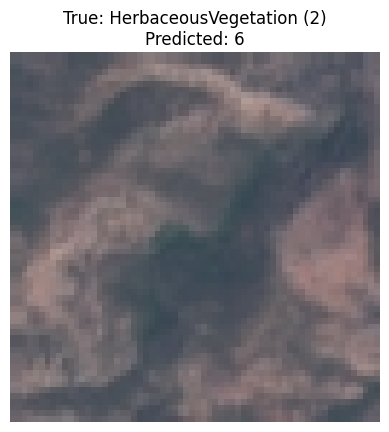


Class probabilities:
0 : 0.1%
1 : 0.0%
2 : 6.7%
3 : 0.1%
4 : 0.0%
5 : 0.2%
6 : 92.9%
7 : 0.0%
8 : 0.0%
9 : 0.0%


In [ ]:
# Load test.csv
test_csv_path = path + "/EuroSAT/test.csv"
test_df = pd.read_csv(test_csv_path)

# Pick a random index
rand_idx = random.randint(0, len(test_df) - 1)

# Get file path & label
img_path = os.path.join(path, "EuroSAT", test_df.iloc[rand_idx, 1])
true_label = test_df.iloc[rand_idx, 2]          # integer label
class_name = test_df.iloc[rand_idx, 3]          # class name column

# Load and preprocess image
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # [1, 3, 64, 64]

# Put model in eval mode and run prediction
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)  # raw logits
    probs = torch.softmax(outputs, dim=1).squeeze()  # remove batch dim
    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {class_name} ({true_label})\nPredicted: {predicted_label}")
plt.show()

# Print probabilities in "index : percentage%" format
print("\nClass probabilities:")
for idx, prob in enumerate(probs):
    print(f"{idx} : {prob.item() * 100:.1f}%")


In [ ]:
# Move model to device
model = model.to(device)

# Accuracy check
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # no .data needed
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 86.74%


In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Path to folder you made using the script earlier
test_images_dir = os.path.join(os.getcwd(), "test_images")

# Collect only image files
image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
num_images = len(image_files)

# Transform (same as used during training/streamlit)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegatation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

correct = 0
total = 0

check_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # percentages
next_cp_idx = 0  # index of next checkpoint

with torch.no_grad():
    for i, fname in enumerate(image_files, start=1):
        # Full path to image file
        img_path = os.path.join(test_images_dir, fname)
        
        # Extract the true class name from front of filename
        true_label_name = fname.split("_")[0]
        
        # Load & preprocess
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dim
        
        # Predict
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label_name = class_names[predicted.item()]
        
        total += 1
        if predicted_label_name == true_label_name:
            correct += 1
        
        # Print progress at each checkpoint
        if i / num_images >= check_points[next_cp_idx]:
            current_acc = 100 * correct / total
            print(f"Progress: {int(check_points[next_cp_idx]*100)}% - Accuracy so far: {current_acc:.2f}% ({correct}/{total})")
            next_cp_idx += 1
            if next_cp_idx >= len(check_points):
                next_cp_idx = len(check_points) - 1  # prevent index error

# Final accuracy
avg_acc = 100 * correct / total
print(f"\nFinal Folder Test Accuracy: {avg_acc:.2f}% ({correct}/{total})")


Progress: 10% - Accuracy so far: 90.37% (244/270)
Progress: 20% - Accuracy so far: 93.33% (504/540)
Progress: 30% - Accuracy so far: 69.14% (560/810)
Progress: 40% - Accuracy so far: 63.89% (690/1080)
Progress: 50% - Accuracy so far: 68.59% (926/1350)
Progress: 60% - Accuracy so far: 70.93% (1149/1620)
Progress: 70% - Accuracy so far: 71.53% (1352/1890)
Progress: 80% - Accuracy so far: 74.81% (1616/2160)
Progress: 90% - Accuracy so far: 74.90% (1820/2430)
Progress: 100% - Accuracy so far: 77.26% (2086/2700)

Final Folder Test Accuracy: 77.26% (2086/2700)
